# Week 04. Machine Learning with Text Data

Natural Language Processing for Law and Social Science<br>
Elliott Ash, ETH Zurich

In [1]:
# set random seed
import numpy as np
np.random.seed(4)

In [4]:
# set up
import warnings; warnings.simplefilter('ignore')
%matplotlib notebook
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df.head()

ValueError: unsupported pickle protocol: 5

In [3]:
df = df.assign(authorship_id=(df['authorship']).astype('category').cat.codes)
df['authorship'].value_counts() 

SCALIA       94
GINSBURG     89
THOMAS       87
KENNEDY      86
BREYER       85
STEVENS      79
SOUTER       77
O'CONNOR     52
REHNQUIST    49
ROBERTS      38
ALITO        32
Name: authorship, dtype: int64

<IPython.core.display.Javascript object>


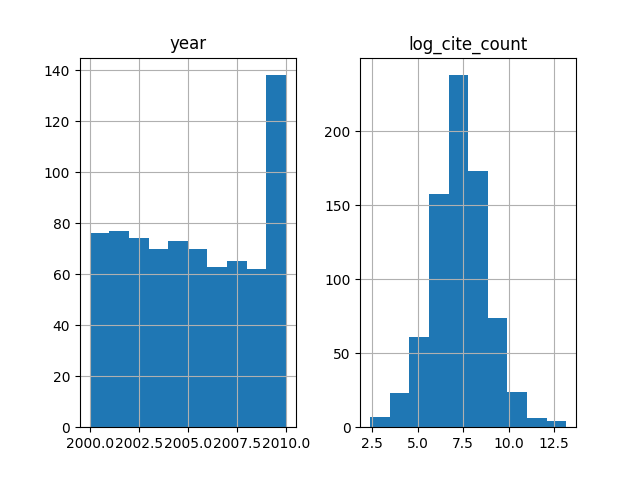

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'log_cite_count'}>]], dtype=object)

In [4]:
df[['year','log_cite_count']].hist()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=4,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['opinion_text'])
words = vectorizer.get_feature_names()
print(words)
X

['act', 'congress', 'district', 'state']


<768x4 sparse matrix of type '<class 'numpy.int64'>'
	with 2534 stored elements in Compressed Sparse Row format>

In [6]:
X = X.todense()
X = X / X.sum(axis=1) # counts to frequencies
for i, word in enumerate(words):
    column = X[:,i]
    df['x_'+word] = column
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,year,log_cite_count,authorship_id,x_act,x_congress,x_district,x_state
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,2003,7.981392,2,0.193548,0.225806,0.161290,0.419355
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,2003,4.762174,9,0.261905,0.095238,0.047619,0.595238
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,2005,10.058952,4,0.012821,0.025641,0.461538,0.500000
3,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,2005,4.430817,3,0.322581,0.129032,0.000000,0.548387
4,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,2005,8.349957,3,0.019231,0.000000,0.596154,0.384615


In [7]:
# inspecting data
import numpy as np
features = ['x_'+x for x in words]
cites_features = ['log_cite_count'] + features
df2 = df[cites_features]
corr_matrix = df2.corr()
corr_matrix['log_cite_count'].sort_values(ascending=False)

log_cite_count    1.000000
x_state           0.153254
x_district        0.111862
x_congress       -0.137626
x_act            -0.237354
Name: log_cite_count, dtype: float64

<IPython.core.display.Javascript object>


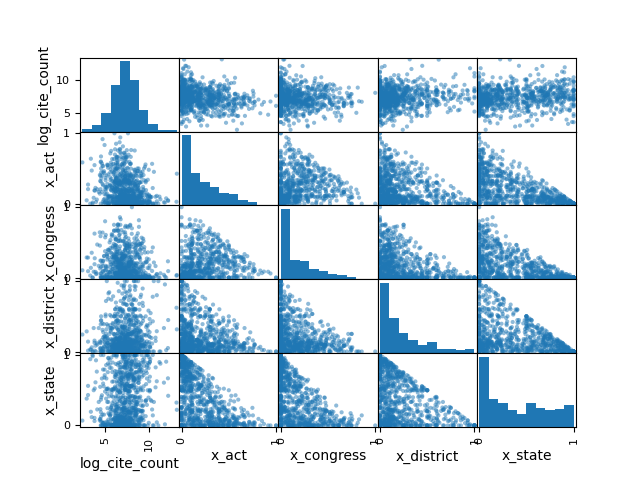

array([[<AxesSubplot:xlabel='log_cite_count', ylabel='log_cite_count'>,
        <AxesSubplot:xlabel='x_act', ylabel='log_cite_count'>,
        <AxesSubplot:xlabel='x_congress', ylabel='log_cite_count'>,
        <AxesSubplot:xlabel='x_district', ylabel='log_cite_count'>,
        <AxesSubplot:xlabel='x_state', ylabel='log_cite_count'>],
       [<AxesSubplot:xlabel='log_cite_count', ylabel='x_act'>,
        <AxesSubplot:xlabel='x_act', ylabel='x_act'>,
        <AxesSubplot:xlabel='x_congress', ylabel='x_act'>,
        <AxesSubplot:xlabel='x_district', ylabel='x_act'>,
        <AxesSubplot:xlabel='x_state', ylabel='x_act'>],
       [<AxesSubplot:xlabel='log_cite_count', ylabel='x_congress'>,
        <AxesSubplot:xlabel='x_act', ylabel='x_congress'>,
        <AxesSubplot:xlabel='x_congress', ylabel='x_congress'>,
        <AxesSubplot:xlabel='x_district', ylabel='x_congress'>,
        <AxesSubplot:xlabel='x_state', ylabel='x_congress'>],
       [<AxesSubplot:xlabel='log_cite_count', ylabel='

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(df2)

<IPython.core.display.Javascript object>


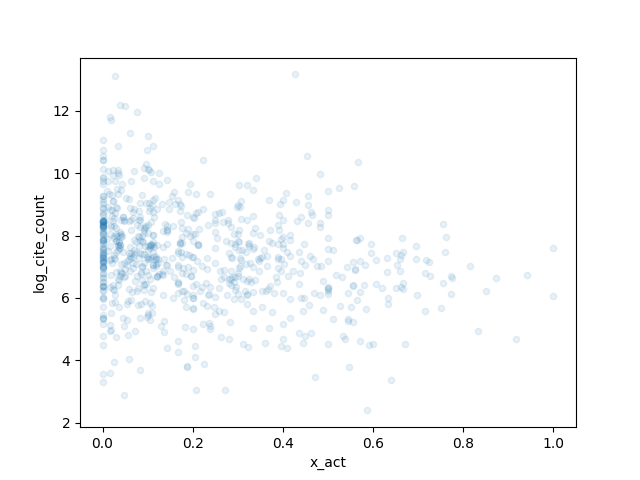

<AxesSubplot:xlabel='x_act', ylabel='log_cite_count'>

In [9]:
df2.plot(kind='scatter', x='x_act', y='log_cite_count', alpha = 0.1)

# Regression

In [10]:
# create a test set 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df2, test_size=0.2)

In [11]:
Xtrain = train[features]
Ytrain = train['log_cite_count']
Xtrain.head()

,x_act,x_congress,x_district,x_state
596,0.173913,0.369565,0.152174,0.304348
90,0.022388,0.000000,0.149254,0.828358
734,0.774194,0.096774,0.096774,0.032258
694,0.282051,0.256410,0.128205,0.333333
517,0.016949,0.000000,0.000000,0.983051


In [12]:
Ytrain.head()

596    8.449771
90     8.477620
734    6.648985
694    5.236442
517    3.583519
Name: log_cite_count, dtype: float64

In [13]:
# our first machine learning model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(Xtrain, Ytrain)
lin_reg.coef_ 

array([-1.05443811, -0.27079188,  0.87434979,  0.45088019])

In [14]:
# in-sample performance
from sklearn.metrics import mean_squared_error
Ytrain_pred = lin_reg.predict(Xtrain)        
train_mse = mean_squared_error(Ytrain,Ytrain_pred)
train_mse

2.1599649495666817

In [15]:
# out-of-sample performance
Xtest = test[features]
Ytest = test['log_cite_count']
Ytest_pred = lin_reg.predict(Xtest)        
test_mse = mean_squared_error(Ytest,Ytest_pred)
test_mse

2.1030016631048745

<IPython.core.display.Javascript object>


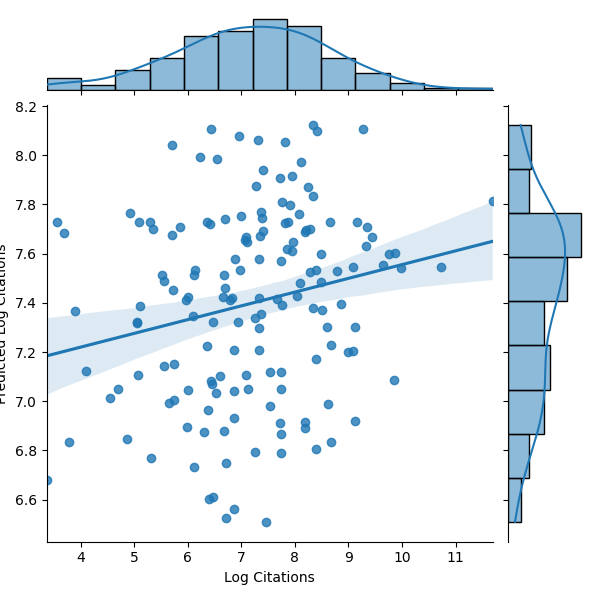

In [16]:
import seaborn as sns

p = sns.jointplot(x=Ytest, y=Ytest_pred, kind='reg')
p.set_axis_labels('Log Citations', 'Predicted Log Citations', fontsize=10)


# Pipelines and Cross-Validation

In [17]:
# missing values
df['authorship_id'].fillna(0,inplace=True)

In [18]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df2)
df2 = pd.DataFrame(X,columns=df2.columns)

In [19]:
X

array([[ 0.4273395 , -0.10042156,  0.26583686, -0.25620003,  0.08875597],
       [-1.69574977,  0.2303693 , -0.38976878, -0.73332927,  0.62993863],
       [ 1.7975002 , -0.97500173, -0.73922735,  1.00407587,  0.33689649],
       ...,
       [ 0.778854  ,  0.31343437,  1.46745168, -0.54274748, -0.70067715],
       [-0.48288351,  0.47521029,  0.43962056,  0.85945227, -1.20157476],
       [ 0.20858247,  0.53243068, -0.86797524, -0.93320774,  0.87744045]])

In [20]:
# Encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
judge = df['authorship_id']
judge_fes = encoder.fit_transform(judge.values.reshape(-1,1))
judge_ids = ['j_'+str(x) for x in range(len(judge.unique()))]
judge_fes = pd.DataFrame(judge_fes.todense(),columns=judge_ids)
df = pd.concat([df,judge_fes],axis=1)
train, test = train_test_split(df, test_size=0.2)

In [21]:
# Encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
judge = df['authorship_id']
judge_fes = encoder.fit_transform(judge.values.reshape(-1,1))
judge_ids = ['j_'+str(x) for x in range(len(judge.unique()))]
judge_fes = pd.DataFrame(judge_fes.todense(),columns=judge_ids)
df = pd.concat([df,judge_fes],axis=1)
train, test = train_test_split(df, test_size=0.2)

In [22]:
# Cross-validation
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg,
                         df[features],
                         df['x_republican'],
                         cv=3,
                         n_jobs=-1)

# the default score for random forest reg is negative MSE.
print(np.abs(scores.mean()),scores.std())

0.07158439367084446 0.04427120481337193


In [23]:
# Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [3, 10, 30],
              'max_features': [2, 4],
              'bootstrap': [True, False]}

grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=3)              
grid_search.fit(df[features],df['x_republican'])

print(grid_search.best_params_)
print(np.abs(grid_search.best_score_))

{'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
0.10601703666326963


In [24]:
from sklearn.model_selection import RandomizedSearchCV
rand_search = RandomizedSearchCV(forest_reg, param_grid, cv=3)              
rand_search.fit(df[features],df['x_republican'])

print(rand_search.best_params_)
print(np.abs(rand_search.best_score_))

{'n_estimators': 30, 'max_features': 2, 'bootstrap': True}
0.08213114206388883


In [ ]:
# Saving and loading
from sklearn.externals import joblib
joblib.dump(forest_reg,'forest_reg.pkl') # will overwrite local files
forest_reg = joblib.load('forest_reg.pkl')

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('forest_reg', RandomForestRegressor()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (2, 4, 8, 16),
    'forest_reg__n_estimators': [3, 10, 30],
    'forest_reg__max_features': [2, 4],
    'forest_reg__bootstrap': [True, False]}

In [27]:
from pprint import pprint
from time import time

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(df.opinion_text, df.log_cite_count)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'forest_reg']
parameters:
{'forest_reg__bootstrap': [True, False],
 'forest_reg__max_features': [2, 4],
 'forest_reg__n_estimators': [3, 10, 30],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (2, 4, 8, 16)}
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done in 554.450s

Best score: 0.182
Best parameters set:
	forest_reg__bootstrap: False
	forest_reg__max_features: 2
	forest_reg__n_estimators: 30
	vect__max_df: 0.75
	vect__max_features: 16


## Nested Cross-Validation

In [28]:
import numpy as np
from sklearn.model_selection import KFold
n = 30

forest_reg = RandomForestRegressor()
non_nested_scores = np.zeros(n)
nested_scores = np.zeros(n)


param_grid = {'n_estimators': [3, 10, 30],
              'max_features': [2, 4],
              'bootstrap': [True, False]}

for i in range(n):

    # Choose cross-validation techniques for the inner and outer loops,

    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    grid_search = GridSearchCV(estimator=forest_reg, param_grid=param_grid, cv=inner_cv)
    grid_search.fit(Xtrain, Ytrain)
    non_nested_scores[i] = grid_search.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(grid_search, X=Xtrain, y=Ytrain, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores
print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))


Average difference of 0.008041 with std. dev. of 0.021027.


# Regularization

In [29]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression

m = 100
x = 6 * np.random.rand(m,1) - 3
y = 0.5 * x ** 2 + x + 2 + np.random.randn(m,1)
y = y.ravel()

from sklearn.preprocessing import PolynomialFeatures
poly_2 = PolynomialFeatures(degree=2) # also adds interactions
X_poly_2 = poly_2.fit_transform(x)


poly_300 = PolynomialFeatures(degree=300) 
X_poly_300 = poly_300.fit_transform(x)


lin_reg = LinearRegression()
cross_val_score(lin_reg, x, y, cv=3, n_jobs=3).mean()

0.39751011925115076

In [30]:
cross_val_score(lin_reg, X_poly_2, y, cv=3, n_jobs=3).mean()

0.7813839684415319

In [31]:
cross_val_score(lin_reg, X_poly_300, y, cv=3, n_jobs=3).mean()

-2.4409029579050945e+25

In [32]:
# Lasso
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
cross_val_score(lasso_reg,x,y).mean()

0.4372437481422473

In [33]:
# Ridge
from sklearn.linear_model import Ridge, SGDRegressor
ridge_reg = Ridge(alpha=1)
cross_val_score(ridge_reg,x,y).mean()

0.43471954056204976

In [34]:
###
# Elastic Net
###
from sklearn.linear_model import ElasticNetCV
enet_reg = ElasticNetCV(alphas=[.0001, .001, .01,.1,1], 
                        l1_ratio=[.0001, .001, .01,.1,.5,.9, .99, 1])
enet_reg.fit(x,y)
enet_reg.alpha_, enet_reg.l1_ratio_

(0.1, 0.0001)

In [35]:
cross_val_score(enet_reg,x,y).mean()

0.4323487671492522

In [37]:
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
from sklearn.linear_model import ElasticNet
enet_reg = ElasticNet(alpha=.1, l1_ratio=.0001)
enet_reg.fit(Xscale,df['x_republican'])
nonzero = enet_reg.coef_ != 0
print(nonzero.sum(),'non-zero of',len(enet_reg.coef_),'coefficients.')
X_enet = X[:,nonzero]
X_enet
cross_val_score(enet_reg,X_enet,df['x_republican'],n_jobs=-1).mean()

5 non-zero of 5 coefficients.


0.009194244568332843

# Classification

In [38]:
# Make a small data set
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer500 = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=500,
                        stop_words='english',
                        ngram_range=(1,3))
X500 = vectorizer500.fit_transform(df['opinion_text']).todense()
X500 = X500 / X500.sum(axis=1) # counts to frequencies
vocab = vectorizer500.get_feature_names()
for i, word in enumerate(vectorizer500.get_feature_names()):
    column = X500[:,i]
    df['x_'+word] = column


features = [x for x in df.columns if x.startswith('x_') and x!="x_republican"]
keepcols = ['x_republican'] + features
df1 = df[keepcols]
y = df1['x_republican']
# set up train/test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.2)
features = [x for x in df1.columns if x.startswith('x_') and x!="x_republican"]
df1.head()

,x_republican,x_000,x_10,x_100,x_101,x_102,x_103,x_104,x_104 ct,x_105,...,x_violated,x_violation,x_water,x_way,x_west,x_words,x_work,x_year,x_years,x_york
0,0.0,0.000000,0.000000,0.000000,0.001709,0.001709,0.001709,0.001709,0.001709,0.001709,...,0.000000,0.003419,0.000000,0.001709,0.000000,0.011966,0.000000,0.017094,0.000000,0.0
1,1.0,0.000000,0.002639,0.000000,0.002639,0.000000,0.000000,0.005277,0.002639,0.000000,...,0.002639,0.000000,0.000000,0.000000,0.005277,0.002639,0.000000,0.000000,0.000000,0.0
2,1.0,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001634,0.000000,0.001634,0.000000,0.000000,0.000000,0.013072,0.001634,0.0
3,1.0,0.000000,0.003652,0.001461,0.000000,0.000000,0.000730,0.000000,0.000000,0.006574,...,0.000000,0.000000,0.013879,0.002922,0.000000,0.000000,0.000000,0.000730,0.002922,0.0
4,1.0,0.001003,0.002006,0.001003,0.000000,0.000000,0.004012,0.000000,0.000000,0.001003,...,0.002006,0.002006,0.000000,0.000000,0.000000,0.000000,0.001003,0.003009,0.001003,0.0


In [39]:
# Binary Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=10) 
sgd_clf.fit(train[features], train['x_republican'])
sgd_clf.score(test[features],test['x_republican']) # accuracy on held-out data

0.7402597402597403

In [40]:
# compare to picking largest category
df1['x_republican'].mean()

0.7734375

In [41]:
from multiprocessing import cpu_count
nthreads = cpu_count() - 1

# Form cross-validated prdictions for all data points
from sklearn.model_selection import cross_val_predict
df1['x_republican_sgd'] = cross_val_predict(sgd_clf,
                                         df1[features],
                                         df1['x_republican'],
                                         cv=3,
                                         n_jobs=nthreads)

After applying a classifier to a data set with known labels `0` and `1`:

<div class="alert alert-block alert-warning">

<div style="font-size: 150%;"><i class="fa fa-info-circle"></i>&nbsp;Definition</div>
<ul>

<li><strong>TP (true positives)</strong>: labels which were predicted as <code>1</code> and actually are <code>1</code>. <br/><br/>


<li><strong>TN (true negatives)</strong>: labels which were predicted as <code>0</code> and actually are <code>0</code>.<br/><br/>


<li><strong>FP (false positives)</strong>: labels which were predicted as <code>1</code> and actually are <code>0</code>.<br/><br/>


<li><strong>FN (false negatives)</strong>: labels which were predicted as <code>0</code> and actually are <code>1</code>.<br/><br/>

</ul>

To memorize this: 

<ul>

<li>The second word "positives"/"negatives" refers to the prediction computed by the classifier.
<li>The first word "true"/"false" expresses if the classification was correct or not.

</ul>

This is the so called <strong>Confusion Matrix</strong>:

<table style="border: 1px; font-family: 'Source Code Pro', monocco, Consolas, monocco, monospace;
              font-size:110%;">
    <tbody >
        <tr>
            <td style="padding: 10px; background:#f8f8f8;"> </td>
            <td style="padding: 10px; background:#f8f8f8;">Predicted N</td>
            <td style="padding: 10px; background:#f8f8f8;">Predicted P</td>
        </tr>
        <tr>
            <td style="padding: 10px; background:#f8f8f8;">Actual N</td>
            <td style="padding: 10px; background:#fcfcfc; text-align:center; font-weight: bold">TN         </td>
            <td style="padding: 10px; background:#fcfcfc; text-align:center; font-weight: bold">FP         </td>
        </tr>
        <tr>
            <td style="padding: 10px; background:#f8f8f8;">Actual P</td>
            <td style="padding: 10px; background:#fcfcfc; text-align:center; font-weight: bold">FN         </td>
            <td style="padding: 10px; background:#fcfcfc; text-align:center; font-weight: bold">TP         </td>
        </tr>
    </tbody>
</table>

</div>



- So the total number of predictions can be expressed as `TP` + `FP` + `FN` + `TN`.


- The number of correct predictions is `TP` + `TN`.


- `TP` + `FN` is the number of positive examples in our data set, 


- `FP` + `TN` is the number of negative examples.

- **precision** is computed as <code>TP / (TP + FP)</code>.


- **recall** is computed as <code>TP / (TP + FN)</code>.

- The **F1 score** is computed as <code>F1 = 2 * (precision * recall) / (precision + recall)</code>.


<div class="alert alert-block alert-warning">
<div style="font-size: 150%;"><i class="fa fa-info-circle"></i>&nbsp;Definition</div>

This allows us to define <strong>accuracy</strong> as (<code>TP</code> + <code>TN</code>) / (<code>TP</code> + <code>FP</code> + <code>FN</code> + <code>TN</code>).

</div>

<IPython.core.display.Javascript object>


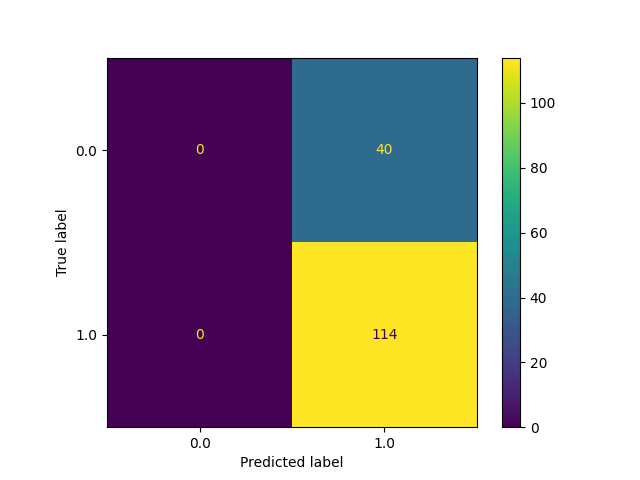

In [47]:
# Construct confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#confusion_matrix(df1['x_republican'], df1['x_republican_sgd'])
plot_confusion_matrix(sgd_clf, test[features],test['x_republican'])

In [43]:
# Precision and Recall
from sklearn.metrics import precision_score, recall_score
print('Precision:',precision_score(df1['x_republican'], df1['x_republican_sgd']))
print('Recall:',recall_score(df1['x_republican'], df1['x_republican_sgd']))

Precision: 0.7734375
Recall: 1.0


In [44]:
#F1 score
from sklearn.metrics import f1_score
f1_score(df1['x_republican'],df1['x_republican_sgd'])

0.8722466960352423

### Precision/Recall Trade Off

<IPython.core.display.Javascript object>


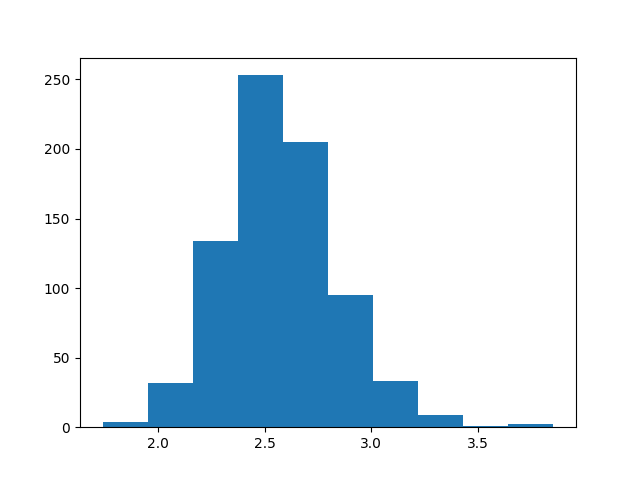

(array([  4.,  32., 134., 253., 205.,  95.,  33.,   9.,   1.,   2.]),
 array([1.7415352 , 1.95265053, 2.16376586, 2.3748812 , 2.58599653,
        2.79711186, 3.0082272 , 3.21934253, 3.43045786, 3.6415732 ,
        3.85268853]),
 <BarContainer object of 10 artists>)

In [48]:
# scores used by SGDClassifier
import matplotlib.pyplot as plt

y_scores = sgd_clf.decision_function(df[features])
plt.hist(y_scores) # histogram of scores

In [49]:
# prediction using default threshold ... 
threshold = 0
(y_scores > threshold).mean()

1.0

In [50]:
# ... gives default model prediction
ypred = sgd_clf.predict(df[features])
ypred.mean()

1.0

In [51]:
# increasing threshold means more zeros are predicted
threshold = 1
(y_scores > threshold).mean()

1.0

<IPython.core.display.Javascript object>


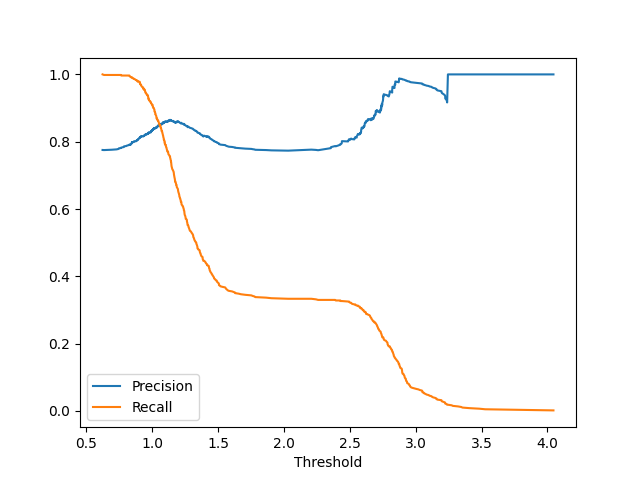

In [52]:
# Visualizing the precision/recall tradeoff
y_scores = cross_val_predict(sgd_clf,
                             df1[features],
                             df1['x_republican'],
                             cv=3,
                             method='decision_function',
                             n_jobs=3)

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(df1['x_republican'], y_scores)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()

In [53]:
# Plot precision vs recall
plt.step(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Precision')

In [54]:
# Assessing other scoring thresholds
ypred_lower = y_scores > -1
ypred_higher = y_scores > 1

print('Precision for Low Threshold:',precision_score(y, ypred_lower))
print('Precision for High Threshold:',precision_score(y, ypred_higher))
print('Recall for Low Threshold:',recall_score(y, ypred_lower))
print('Recall for High Threshold:',recall_score(y, ypred_higher))

Precision for Low Threshold: 0.7734375
Precision for High Threshold: 0.8346213292117465
Recall for Low Threshold: 1.0
Recall for High Threshold: 0.9090909090909091


<IPython.core.display.Javascript object>


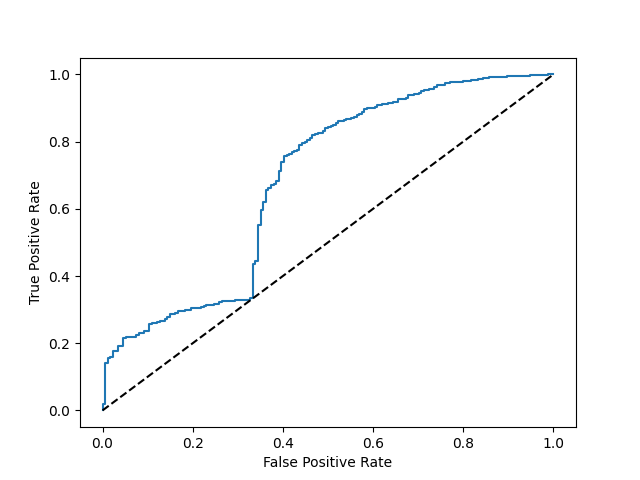

Text(0, 0.5, 'True Positive Rate')

In [55]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [56]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_scores)

0.6847594721157939

In [57]:
# Random Forests and predict_proba()
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
y_probas_rfc = cross_val_predict(rfc,
                                 X500,
                                 y,
                                 cv=3,
                                 method='predict_proba',
                                 n_jobs=3)

y_scores_rfc = y_probas_rfc[:,1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y,y_scores_rfc) 

# compare precision/recall tradeoff for SGD and RF classifiers
plt.plot(fpr, tpr, label="SGD")
plt.plot(fpr_rfc, tpr_rfc, label="RF")
plt.legend()

<IPython.core.display.Javascript object>

In [58]:
roc_auc_score(y,y_scores_rfc)

0.8887195711908356

## Multinomial Classification

In [59]:
author = df['authorship']
authpred = cross_val_predict(sgd_clf,
                              X500,
                              author,
                              cv=7)
print((authpred == author).mean())
list(zip(author[:8],authpred[:8]))

0.21744791666666666


[('GINSBURG', 'GINSBURG'),
 ('STEVENS', 'STEVENS'),
 ("O'CONNOR", 'KENNEDY'),
 ('KENNEDY', 'SOUTER'),
 ('KENNEDY', 'KENNEDY'),
 ('SOUTER', 'SOUTER'),
 ('BREYER', 'SOUTER'),
 ('GINSBURG', 'GINSBURG')]

<IPython.core.display.Javascript object>


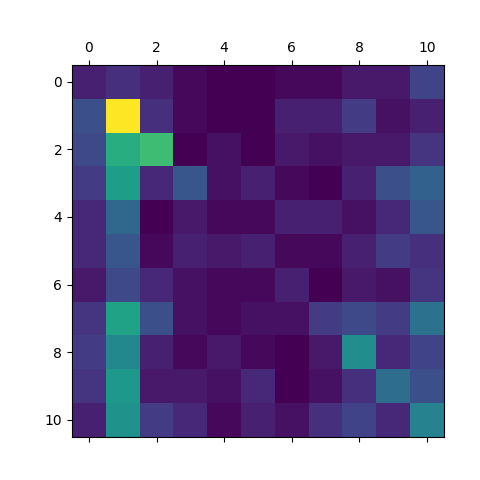

In [60]:
# Multi-class confusion matrix
conf_mx = confusion_matrix(author,authpred)
conf_mx
plt.matshow(conf_mx)
plt.show()

<IPython.core.display.Javascript object>


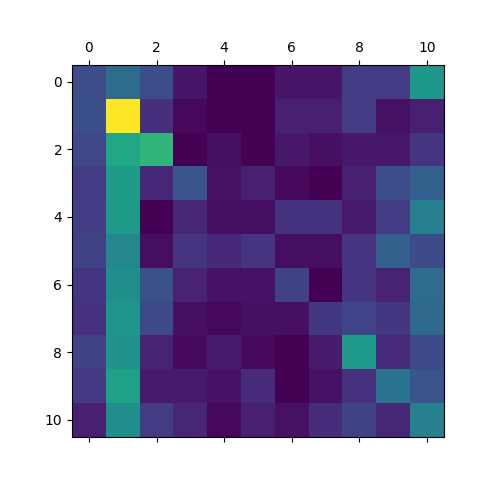

In [61]:
# normalize colors
conf_mx_norm = conf_mx / conf_mx.sum(axis=1, keepdims=True)
plt.matshow(conf_mx_norm)

## Multinomial Logistic

In [64]:

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C=1, # default L2 penalty # .01, .1, 1, 2, 10
                              class_weight='balanced')

scores = cross_val_score(logistic,
                         Xscale[:1000],
                         author[:1000],
                         cv=3,
                         n_jobs=3)

scores.mean(), scores.std()

(0.09765625, 0.01390244564066577)

# Ensemble Learning

In [65]:
Y = df1['x_republican'] > 0

# Bagging classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=50,
        max_samples=100, bootstrap=True, n_jobs=-1
    )

cross_val_score(bag_clf, X500, Y).mean()

0.795586113233172

In [66]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1)
y_pred_rf = cross_val_predict(rnd_clf, X500, Y)                              
confusion_matrix(Y,y_pred_rf)

array([[  2, 172],
       [  0, 594]])

In [67]:
rnd_clf.fit(X500,Y)
feature_importances = rnd_clf.feature_importances_
sorted(zip(feature_importances, word), reverse=False)

[(0.0009572418864364776, 'k'),
 (0.0010358544276956854, 'o'),
 (0.0011153699385341863, 'y'),
 (0.004262871674066923, 'r')]

In [68]:
# XGBoost
from xgboost import XGBClassifier, XGBRegressor
dfX = pd.DataFrame(X500,columns=vocab)
xgb_clf = XGBClassifier()
cross_val_score(xgb_clf, dfX, Y).mean()

[18:15:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:15] WARNING: /home/conda/feedstock_r

0.8749681690858161

In [69]:
xgb_reg = XGBRegressor(feature_names=vocab)
xgb_reg.fit(dfX,Y)
sorted(zip(xgb_reg.feature_importances_, vocab),reverse=True)[:10]

[18:15:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[(0.033571467, 'analysis'),
 (0.031830117, 'new york'),
 (0.029660394, 'granted certiorari'),
 (0.026276005, 'sought'),
 (0.025258552, 'related'),
 (0.02393513, 'stated'),
 (0.023086436, 'internal quotation'),
 (0.021765428, 'require'),
 (0.021112507, 'light'),
 (0.021009024, 'added')]

<IPython.core.display.Javascript object>


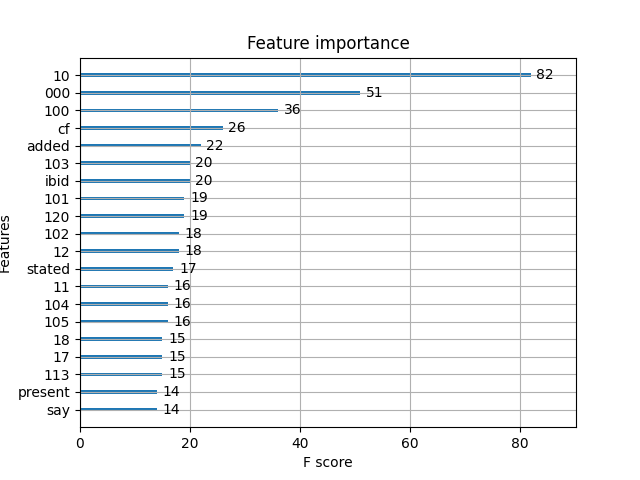

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [70]:
from xgboost import plot_importance
plot_importance(xgb_reg, max_num_features=20)